In [11]:
%matplotlib widget
import numpy as np
import magpylib as magpy
from magpylib import Collection
import zMag_field_lib4 as mag
from tqdm import tqdm

In [20]:
def update_position_velocity(position, velocity, force, mass, dt= 0.005):
    """
    Updates position and velocity using force and time step (basic Newtonian mechanics).
    
    Parameters:
        position (tuple): Current (x, y, z) position.
        velocity (tuple): Current (vx, vy, vz) velocity.
        force (tuple): Force vector (Fx, Fy, Fz).
        mass (float): Mass of the object.
        dt (float): Time step.
    
    Returns:
        tuple: Updated (position, velocity)
    """
    x, y, z = position
    vx, vy, vz = velocity
    Fx, Fy, Fz = force

    # Acceleration
    ax = Fx / mass
    ay = Fy / mass
    az = Fz / mass

    # Update velocity
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt

    # Update position
    x_new = x + vx * dt + 0.5 * ax * dt**2
    y_new = y + vy * dt + 0.5 * ay * dt**2
    z_new = z + vz * dt + 0.5 * az * dt**2

    return (x_new, y_new, z_new), (vx_new, vy_new, vz_new)


def scale_position_to_hall(x):
    center = 530
    hall_range = 1060  # Assuming 0 to 1060
    physical_range = 0.01  # Example: ±1 cm = 2 cm total range
    scale = (hall_range / 2) / physical_range  # Scale meters → hall units
    return center + np.array(x) * scale  # np.array ensures element-wise mult


def scale_hall_to_position(hall_value, physical_range=0.025, center=530, hall_range=1023):
    """
    Maps a Hall sensor reading back to physical position in meters.

    Parameters:
        hall_value (float): Simulated or real Hall sensor reading (0–1023)
        physical_range (float): Max range from center position (e.g., ±0.025 m)
        center (int): Hall sensor value for zero position (default 530)
        hall_range (int): Max value of Hall sensor (default 1023)

    Returns:
        float: Physical position in meters
    """
    scale = (hall_range / 2) / physical_range  # Same scale as forward mapping
    return (hall_value - center) / scale


In [13]:
from simple_pid import PID
for current in np.linspace(-5, 5, 11):
    force = mag.force_for_position(current, 0.0, [0.002, 0.0, 0.03])

    print(f"Current: {current:.1f}, Fx: {force[0]:.5f}")
    force = mag.force_for_position(0, current ,[0.002, 0.0, 0.03])
    print(f"Current: {current:.1f}, Fy: {force[0]:.5f}")


Current: -5.0, Fx: -0.05684
Current: -5.0, Fy: -0.05684
Current: -4.0, Fx: -0.04547
Current: -4.0, Fy: -0.04547
Current: -3.0, Fx: -0.03411
Current: -3.0, Fy: -0.03411
Current: -2.0, Fx: -0.02274
Current: -2.0, Fy: -0.02274
Current: -1.0, Fx: -0.01137
Current: -1.0, Fy: -0.01137
Current: 0.0, Fx: 0.00000
Current: 0.0, Fy: 0.00000
Current: 1.0, Fx: 0.01137
Current: 1.0, Fy: 0.01137
Current: 2.0, Fx: 0.02274
Current: 2.0, Fy: 0.02274
Current: 3.0, Fx: 0.03411
Current: 3.0, Fy: 0.03411
Current: 4.0, Fx: 0.04547
Current: 4.0, Fy: 0.04547
Current: 5.0, Fx: 0.05684
Current: 5.0, Fy: 0.05684


In [17]:
pid_x = PID(1.0, 0.0, 0.0, setpoint=530, output_limits=(-255, 255))
pid_y = PID(1.0, 0.0, 0.0, setpoint=530, output_limits=(-255, 255))
x_current = 0
y_current = 0
magnetic_moment = (0.0, 0.0, 2.06)  # A·m²
position = np.array([0.001, -0.001, 0.03])  # Starting position of the magnet
velocity = np.array([0.0, 0.0, 0.0])  # Starting velocity of the magnet
mass = 0.025  # kg
dt = 0.005  # seconds
trajectory = []

# Assume initial coil currents (can start at 0)
current_x = 0
current_y = 0

MAX_CURRENT = 5.0  # Amps
MAX_PWM = 255


for step in tqdm(range(40)):
    x, y, z = position
    Input_X = scale_position_to_hall(x)
    Input_Y = scale_position_to_hall(y)

    # 1. PID computes desired current adjustment
    pwm_delta_x = pid_x(Input_X)
    pwm_delta_y = pid_y(Input_Y)
    
    # 2. Convert PWM change to actual current (Amps)
    delta_Ix = (pwm_delta_x / MAX_PWM) * MAX_CURRENT
    delta_Iy = (pwm_delta_y / MAX_PWM) * MAX_CURRENT

    # 2. Update the actual coil currents
    current_x += delta_Ix
    current_y += delta_Iy


    # 2. Update the actual coil currents with limits
    current_x = np.clip(current_x , -MAX_CURRENT, MAX_CURRENT)
    current_y = np.clip(current_y , -MAX_CURRENT, MAX_CURRENT)


    # 3. Update the current in the coils
    force = mag.force_for_position(current_x, current_y, position)
    force = np.array(force)
    # 5. Zero out Z if we're assuming it's fixed
    force[2] = 0.0
    #print(f"Currents: ({current_x:.2f}, {current_y:.2f}), Position: ({x:.4f}, {y:.4f}), Force: {force}")

    # 6. Update position from force
    position, velocity = update_position_velocity(position, velocity , force, mass, dt)
    
    # 7. Save trajectory
    trajectory.append(position)


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:19<00:00,  2.09it/s]


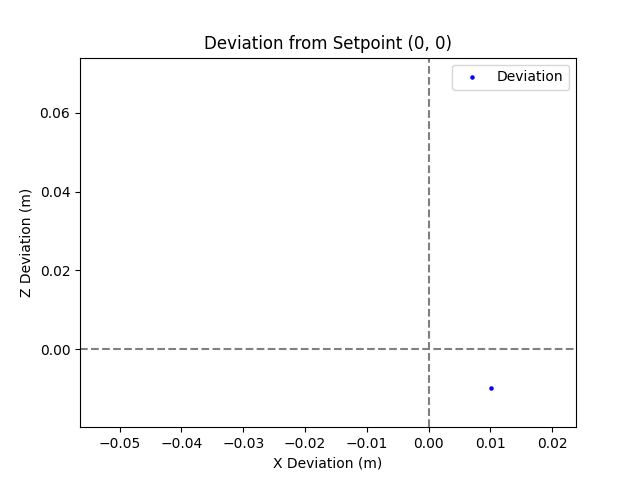

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_pos_list(positions):
    # Compute deviation from setpoint (0, 0)
    deviations = [(pos[0], pos[1]) for pos in positions]  # X and Z deviation only

    x_deviation = [dev[0] for dev in deviations]
    z_deviation = [dev[1] for dev in deviations]

    # Plot setup
    fig, ax = plt.subplots()
    scat = ax.scatter(x_deviation[0], z_deviation[0], c="b", s=5, label='Deviation')
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set(
        xlim=[min(x_deviation) - 0.01, max(x_deviation) + 0.01],
        ylim=[min(z_deviation) - 0.01, max(z_deviation) + 0.01],
        xlabel='X Deviation (m)',
        ylabel='Z Deviation (m)',
        title='Deviation from Setpoint (0, 0)'
    )
    ax.legend()

    # Update function
    def update(frame):
        x = x_deviation[:frame]
        z = z_deviation[:frame]
        scat.set_offsets(np.column_stack([x, z]))
        return scat,

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=100, blit=False)
    return ani

animate_pos_list(trajectory)


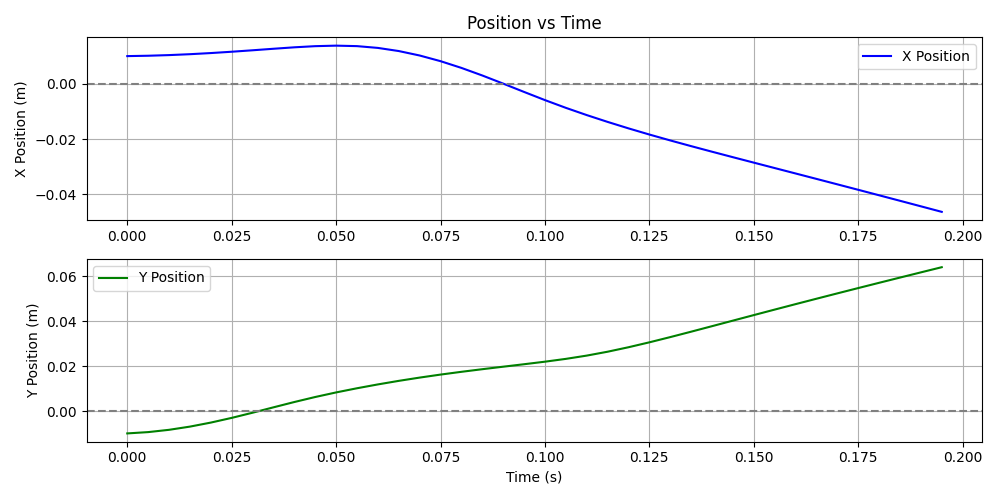

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_position_vs_time(positions, dt=0.005):
    times = np.arange(len(positions)) * dt
    x_positions = [pos[0] for pos in positions]
    y_positions = [pos[1] for pos in positions]

    plt.figure(figsize=(10, 5))

    # Plot X vs Time
    plt.subplot(2, 1, 1)
    plt.plot(times, x_positions, label='X Position', color='blue')
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel('X Position (m)')
    plt.title('Position vs Time')
    plt.grid(True)
    plt.legend()

    # Plot Y vs Time
    plt.subplot(2, 1, 2)
    plt.plot(times, y_positions, label='Y Position', color='green')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_position_vs_time(trajectory, dt=dt)

In [22]:
def compute_loss(trajectory, target=530):
    errors = [np.linalg.norm(scale_position_to_hall(pos[:2]) - target) for pos in trajectory]
    return np.mean(np.square(errors))
from scipy.optimize import minimize

def pid_loss(params):
    Kp, Ki, Kd = params
    # Simulate the system with these PID params (run the loop)
    # Return the loss (e.g. MSE or final error)
    return compute_loss(trajectory)

result = minimize(pid_loss, x0=[1.0, 0.0, 0.0], bounds=[(0,10), (0,1), (0,1)])
print(result)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 4459.151903589698
        x: [ 1.000e+00  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
     nfev: 4
     njev: 1
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [30]:
def simulate_with_pid(Kp, Ki, Kd, steps=40):
    # Set up PIDs
    pid_x = PID(Kp, Ki, Kd, setpoint=530, output_limits=(-255, 255))
    pid_y = PID(Kp, Ki, Kd, setpoint=530, output_limits=(-255, 255))

    # Initial values
    position = np.array([0.001, -0.001, 0.03])
    velocity = np.array([0.0, 0.0, 0.0])
    current_x = 0.0
    current_y = 0.0
    mass = 0.025
    dt = 0.005
    MAX_CURRENT = 5.0
    MAX_PWM = 255
    trajectory = []

    for _ in tqdm(range(steps)):
        x, y, z = position
        Input_X = scale_position_to_hall(x)
        Input_Y = scale_position_to_hall(y)

        pwm_delta_x = pid_x(Input_X)
        pwm_delta_y = pid_y(Input_Y)

        delta_Ix = (pwm_delta_x / MAX_PWM) * MAX_CURRENT
        delta_Iy = (pwm_delta_y / MAX_PWM) * MAX_CURRENT

        current_x += delta_Ix
        current_y += delta_Iy

        current_x = np.clip(current_x, -MAX_CURRENT, MAX_CURRENT)
        current_y = np.clip(current_y, -MAX_CURRENT, MAX_CURRENT)

        force = mag.force_for_position(current_x, current_y, position)
        force = np.array(force)
        force[2] = 0.0  # assume no Z force

        position, velocity = update_position_velocity(position, velocity, force, mass, dt)
        trajectory.append(position)

    return trajectory


In [31]:
def compute_loss(trajectory, target_hall=530):
    total_error = 0.0
    for pos in trajectory:
        x_hall = scale_position_to_hall(pos[0])
        y_hall = scale_position_to_hall(pos[1])
        error_x = (x_hall - target_hall)
        error_y = (y_hall - target_hall)
        total_error += error_x**2 + error_y**2
    return total_error / len(trajectory)


In [ ]:
from scipy.optimize import minimize

def pid_loss(params):
    Kp, Ki, Kd = params
    trajectory = simulate_with_pid(Kp, Ki, Kd)
    loss = compute_loss(trajectory)
    print(f"For params: {params}, loss: {loss}")
    return loss

# Run optimization
result = minimize(
    pid_loss,
    x0=[1.0, 0.0, 0.0],
    bounds=[(0.01, 10.0), (0.0, 1.0), (0.0, 1.0)],
    method='L-BFGS-B',
    options={"finite_diff_rel_step": 0.2} 
)

print("Best PID parameters found:", result.x)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3394878325.py, line 15)

In [ ]:
best_Kp, best_Ki, best_Kd = result.x
best_trajectory = simulate_with_pid(best_Kp, best_Ki, best_Kd)

xs = [p[0] for p in best_trajectory]
ys = [p[1] for p in best_trajectory]
plt.plot(xs, ys, label="Trajectory")
plt.scatter([0], [0], c='green', label="Target")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("Best PID Trajectory")
plt.grid(True)
plt.show()
